<a id="top"></a>
# 01A_PREP_BALANCED — Splits estratificados + **Balanceo offline por imágenes**

**Qué hace este notebook:**  
Realiza la **preparación completa** para cada *run* (p. ej., `circuito1`, `circuito2`) admitiendo **subcarpetas** de vueltas (`vuelta1/`, `vuelta2/`, …) y añade un **balanceo offline** del conjunto de entrenamiento (`train_balanced.csv`) por *bins* de `steering`. Genera/actualiza:
- `data/processed/tasks.json` (splits originales), y
- `data/processed/tasks_balanced.json` (si activas balanceo).

**Características clave:**
- Lee parámetros desde `configs/presets.yaml` (sección `prep`, si existe).
- Autodetecta `RUNS` dentro de `data/raw/udacity/*` si no están en el preset.
- Puede **fusionar varias vueltas** por circuito (`merge_subruns`).
- Puede **expandir cámaras L/R** a centro con corrección de ángulo (`use_left_right + steer_shift`).
- **Balancea offline** el `train` generando imágenes aumentadas para rellenar *bins* infrarrepresentados.
- Escribe un `prep_manifest.json` con la **trazabilidad**.

**Diferencia con `01_DATA_QC_PREP.ipynb`:**  
`01_DATA_QC_PREP` hace **QC + splits** sin balanceo offline (y por defecto sin expansión L/R).  
Este cuaderno hace **QC + splits** y, además, **balanceo offline** (y suele activar la expansión L/R).

---
<a id="toc"></a>
## 🧭 Índice
1. [Configuración y parámetros del balanceo offline](#sec-01)
2. [Ejecutar preparación + verificación y escribir `tasks_balanced.json`](#sec-02)
3. [EDA rápida y resumen por circuitos](#sec-03)
4. [Paso a paso (opcional) — depuración](#sec-04)
5. [Histogramas: original vs balanced](#sec-05)


<a id="sec-01"></a>
## 1) Configuración y parámetros del balanceo offline {#a1}

**Objetivo del notebook:**  
Generar para cada *run* un `train_balanced.csv` equilibrado por *bins* de `steering`, y construir un `tasks_balanced.json` listo para los experimentos de continual learning.

Esta celda:
- Define `ROOT` y prepara importaciones de `src.prep.data_prep`.
- Carga (si existe) la sección `prep` del `configs/presets.yaml`.
- Establece rutas base `RAW` y `PROC`.
- Determina `RUNS`: usa los del preset si están definidos; si no, **autodetecta** circuitos con al menos un `driving_log.csv` en cualquier nivel.
- Declara hiperparámetros de *prep* y de **balanceo offline**:
  - `merge_subruns`, `use_left_right`, `steer_shift`.
  - `bins`, `train`, `val`, `seed`.
  - `balance_offline`: `mode`, `target_per_bin`, `cap_per_bin`, `aug`.

[↑ Volver al índice](#toc)



In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys, json
import pandas as pd

ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.prep.data_prep import PrepConfig, run_prep, verify_processed_splits
from src.prep.augment_offline import balance_train_with_augmented_images

try:
    from src.config import load_preset
    PRESET = "fast"  # cámbialo si quieres
    _cfg = load_preset(ROOT / "configs" / "presets.yaml", PRESET)
    PREP = _cfg.get("prep", {})
except Exception:
    PREP = {}

RAW  = ROOT / "data" / "raw" / "udacity"
PROC = ROOT / "data" / "processed"

# RUNS: preset o autodetección robusta
if "runs" in PREP and PREP["runs"]:
    RUNS = list(PREP["runs"])
else:
    RUNS = sorted({
        p.parents[1].name
        for p in RAW.rglob("driving_log.csv")
        if "aug" not in p.parts
    })

# Hiperparámetros de preparación
merge_subruns   = bool(PREP.get("merge_subruns", True))
use_left_right  = bool(PREP.get("use_left_right", True))
steer_shift     = float(PREP.get("steer_shift", 0.2))
bins            = int(PREP.get("bins", 50))
train           = float(PREP.get("train", 0.70))
val             = float(PREP.get("val", 0.15))
seed            = int(PREP.get("seed", 42))

# Balanceo offline
BAL = dict(PREP.get("balance_offline", {}))
bal_mode       = str(BAL.get("mode", "images")).lower()
target_per_bin = BAL.get("target_per_bin", "auto")
cap_per_bin    = BAL.get("cap_per_bin", 12000)
AUG            = BAL.get("aug", {})

# PrepConfig SIN duplicación de filas (la hace el balanceo)
CFG = PrepConfig(
    root=ROOT,
    runs=RUNS,
    merge_subruns=merge_subruns,
    use_left_right=use_left_right,
    steer_shift=steer_shift,
    bins=bins,
    train=train,
    val=val,
    seed=seed,
    target_per_bin=None,
    cap_per_bin=None,
)

print("ROOT:", ROOT)
print("RAW :", RAW)
print("PROC:", PROC)
print("RUNS:", RUNS)
print("BAL mode:", bal_mode, "| target_per_bin:", target_per_bin, "| cap_per_bin:", cap_per_bin)


ROOT: /home/cesar/proyectos/TFM_SNN
RAW : /home/cesar/proyectos/TFM_SNN/data/raw/udacity
PROC: /home/cesar/proyectos/TFM_SNN/data/processed
RUNS: ['circuito1', 'circuito2']
BAL mode: images | target_per_bin: auto | cap_per_bin: 12000


<a id="sec-02"></a>
## 2) Ejecutar preparación + verificación y escribir `tasks_balanced.json`

**Secuencia:**
1. Ejecuta `manifest = run_prep(CFG)`:
   - `canonical.csv` por *run* (rutas normalizadas y fusión de subvueltas si procede).
   - `train.csv`, `val.csv`, `test.csv` (splits estratificados).
   - `data/processed/tasks.json` (orden de tareas y rutas).
2. Verifica que `train/val/test.csv` existen para cada *run* (`verify_processed_splits`).
3. Si `bal_mode == "images"`:
   - Para cada *run*, genera `train_balanced.csv` por *bins* (aumentación fotométrica) con `balance_train_with_augmented_images(...)`.
   - Escribe `tasks_balanced.json` con rutas a `train_balanced.csv`/`val.csv`/`test.csv`.

**Idempotencia:** con `idempotent=True` no regenera si la configuración coincide; `overwrite=False` evita sobrescrituras accidentales.

[↑ Volver al índice](#toc)


In [2]:
manifest = run_prep(CFG)
print("prep_manifest.json:", PROC / "prep_manifest.json")
print("tasks.json:", manifest["outputs"].get("tasks_json", "(desconocido)"))

# Verificación básica
verify_processed_splits(PROC, RUNS)

if bal_mode == "images":
    stats_all = {}
    for run in RUNS:
        base_dir = RAW  / run
        out_dir  = PROC / run
        train_csv = out_dir / "train.csv"

        out_csv, stats = balance_train_with_augmented_images(
            train_csv=train_csv,
            raw_run_dir=base_dir,
            out_run_dir=out_dir,
            bins=CFG.bins,
            target_per_bin=target_per_bin,
            cap_per_bin=cap_per_bin,
            seed=CFG.seed,
            aug=AUG,
            idempotent=True,
            overwrite=False,
        )
        stats_all[run] = stats
        print(f"[{run}] +{stats.get('generated', 0)} nuevas → {out_csv.name}")

    # Escribir tasks_balanced.json
    tb = {"tasks_order": RUNS, "splits": {}}
    for run in RUNS:
        d = str((PROC / run).resolve())
        tb["splits"][run] = {
            "train": f"{d}/train_balanced.csv",
            "val":   f"{d}/val.csv",
            "test":  f"{d}/test.csv",
        }
    tasks_balanced_path = PROC / PREP.get("tasks_balanced_file_name", "tasks_balanced.json")
    tasks_balanced_path.write_text(json.dumps(tb, indent=2), encoding="utf-8")
    print("OK BALANCED:", tasks_balanced_path)
else:
    print("Balanceo offline desactivado (prep.balance_offline.mode != 'images').")


prep_manifest.json: /home/cesar/proyectos/TFM_SNN/data/processed/prep_manifest.json
tasks.json: /home/cesar/proyectos/TFM_SNN/data/processed/tasks.json
[augment_offline] Balanceo ya existente con la misma configuración; no se regenera.
[circuito1] +269264 nuevas → train_balanced.csv
[augment_offline] Balanceo ya existente con la misma configuración; no se regenera.
[circuito2] +86117 nuevas → train_balanced.csv
OK BALANCED: /home/cesar/proyectos/TFM_SNN/data/processed/tasks_balanced.json


<a id="sec-03"></a>
## 3) EDA rápida y resumen por circuitos

**Qué proporciona esta sección:**
- Chequeo de subvueltas integradas en `canonical.csv` (p. ej., `vuelta1/`, `vuelta2/`…).
- Tamaños y **factor de expansión** (≈3 si se activa L/R sin pérdidas).
- Histogramas de `steering` por split y, si existe, `train_balanced`.
- **Tabla de cuentas por bin** (`bins_counts.csv`) por circuito (para la memoria).
- Resumen JSON por circuito y **resumen global** `data/processed/eda_all/summary_runs.csv`.

[↑ Volver al índice](#toc)


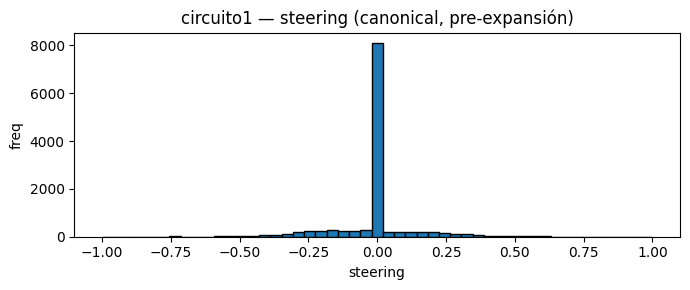

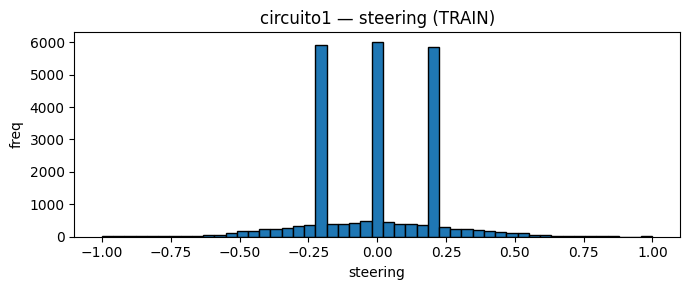

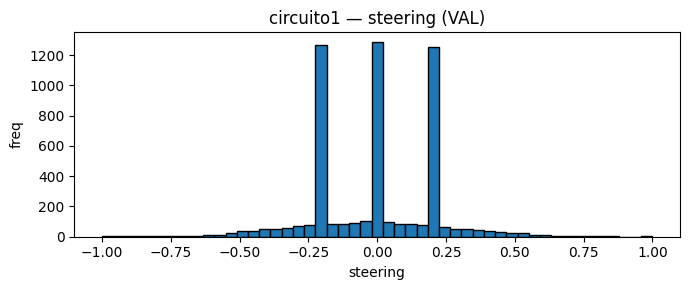

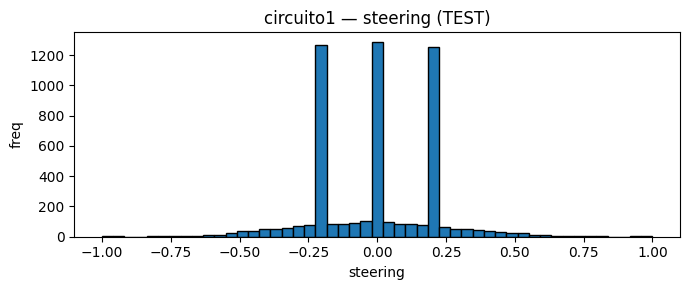

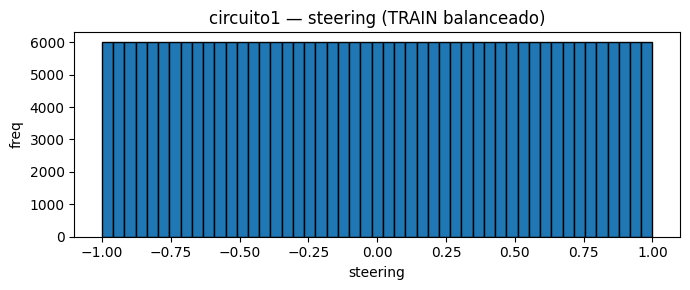

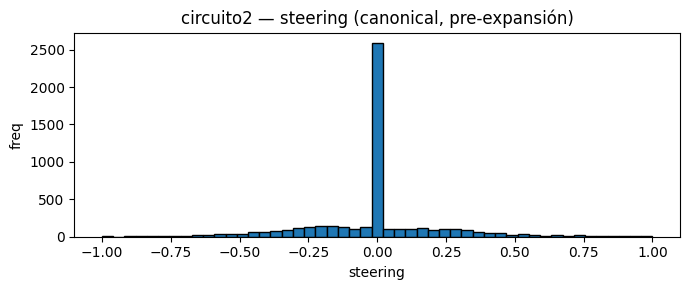

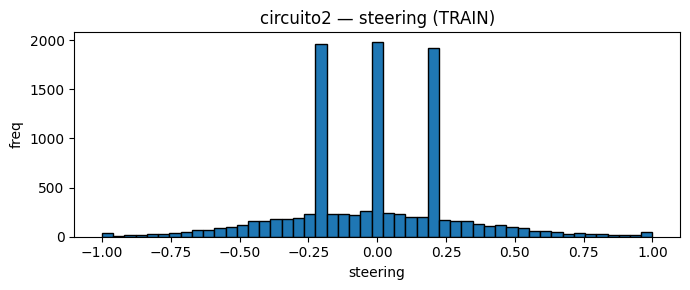

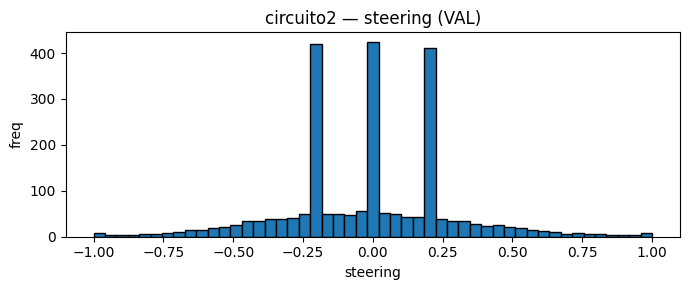

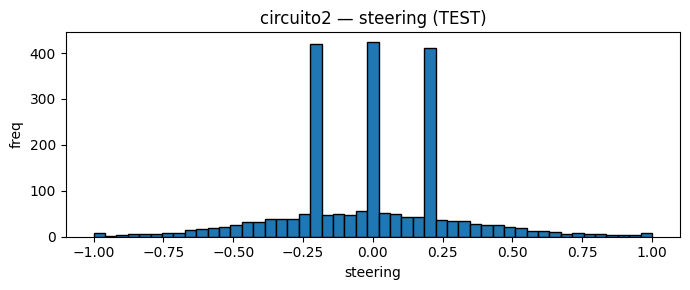

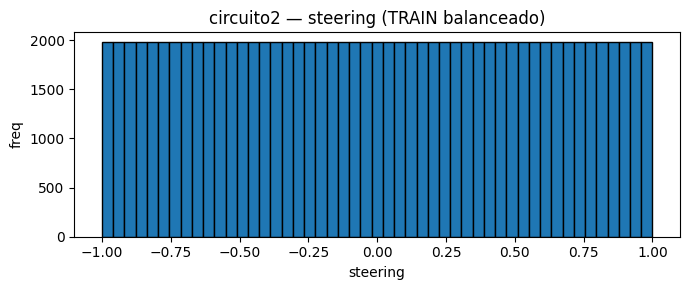

,run,n_subruns,n_canonical,n_train,n_val,n_test,n_total_after_expand,expansion_factor,has_train_balanced
0,circuito1,4,11895,24981,5357,5347,35685,3.0,True
1,circuito2,4,5168,10854,2325,2325,15504,3.0,True


Guardado resumen global: /home/cesar/proyectos/TFM_SNN/data/processed/eda_all/summary_runs.csv


In [3]:
from pathlib import Path
import json, numpy as np, pandas as pd
import matplotlib.pyplot as plt

def _top_folder(pathstr: str) -> str:
    s = str(pathstr).replace("\\","/").lstrip("/")
    return s.split("/")[0] if "/" in s else s

def _plot_hist(series, title, edges, save_path=None):
    s = pd.to_numeric(series, errors="coerce").dropna().clip(-1,1)
    plt.figure(figsize=(7,3))
    plt.hist(s, bins=edges, edgecolor="black")
    plt.title(title); plt.xlabel("steering"); plt.ylabel("freq")
    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=140)
    plt.show(); plt.close()

def _bin_counts(series, edges):
    s = pd.to_numeric(series, errors="coerce").dropna().clip(-1,1)
    idx = pd.cut(s, bins=edges, include_lowest=True, labels=False)
    vc = idx.value_counts().sort_index()
    labels = [(f"[{edges[i]:.2f},{edges[i+1]:.2f})" if i < len(edges)-2 else f"[{edges[i]:.2f},{edges[i+1]:.2f}]")
              for i in range(len(edges)-1)]
    return pd.DataFrame({"bin": labels, "count": vc.reindex(range(len(edges)-1)).fillna(0).astype(int).values})

bins = CFG.bins
edges = np.linspace(-1.0, 1.0, bins)
rows_summary = []

for RUN in RUNS:
    base_out = PROC / RUN
    if not base_out.exists():
        print(f"[WARN] {RUN}: no existe {base_out}, salto.")
        continue

    df_c  = pd.read_csv(base_out / "canonical.csv")  # pre-expansión
    df_tr = pd.read_csv(base_out / "train.csv")
    df_va = pd.read_csv(base_out / "val.csv")
    df_te = pd.read_csv(base_out / "test.csv")
    df_bal = pd.read_csv(base_out / "train_balanced.csv") if (base_out / "train_balanced.csv").exists() else None

    # Subvueltas detectadas en canonical
    df_c["subrun"] = df_c["center"].map(_top_folder)
    subruns = df_c["subrun"].value_counts().sort_index()

    # Tamaños y factor de expansión
    n_c = len(df_c)
    n_tr, n_va, n_te = len(df_tr), len(df_va), len(df_te)
    n_all = n_tr + n_va + n_te
    factor_expansion = (n_all / n_c) if n_c else float("nan")

    eda_dir = base_out / "eda"
    eda_dir.mkdir(parents=True, exist_ok=True)

    # Histogramas
    _plot_hist(df_c["steering"],  f"{RUN} — steering (canonical, pre-expansión)", edges, eda_dir/"hist_canonical.png")
    _plot_hist(df_tr["steering"], f"{RUN} — steering (TRAIN)", edges, eda_dir/"hist_train.png")
    _plot_hist(df_va["steering"], f"{RUN} — steering (VAL)", edges, eda_dir/"hist_val.png")
    _plot_hist(df_te["steering"], f"{RUN} — steering (TEST)", edges, eda_dir/"hist_test.png")
    if df_bal is not None:
        _plot_hist(df_bal["steering"], f"{RUN} — steering (TRAIN balanceado)", edges, eda_dir/"hist_train_balanced.png")

    # Tabla de bins
    tbl = (_bin_counts(df_c["steering"], edges).rename(columns={"count":"count_canonical"})
           .merge(_bin_counts(df_tr["steering"], edges).rename(columns={"count":"count_train"}), on="bin")
           .merge(_bin_counts(df_va["steering"], edges).rename(columns={"count":"count_val"}), on="bin")
           .merge(_bin_counts(df_te["steering"], edges).rename(columns={"count":"count_test"}), on="bin"))
    if df_bal is not None:
        tbl = tbl.merge(_bin_counts(df_bal["steering"], edges).rename(columns={"count":"count_train_bal"}), on="bin", how="left")

    tbl.to_csv(eda_dir/"bins_counts.csv", index=False)
    (eda_dir/"summary.json").write_text(json.dumps({
        "run": RUN,
        "subruns": subruns.to_dict(),
        "n_canonical": int(n_c),
        "n_train": int(n_tr),
        "n_val": int(n_va),
        "n_test": int(n_te),
        "n_total_after_expand": int(n_all),
        "expansion_factor": float(factor_expansion),
        "bins": int(bins),
        "has_train_balanced": bool(df_bal is not None),
    }, indent=2), encoding="utf-8")

    rows_summary.append({
        "run": RUN,
        "n_subruns": int(len(subruns)),
        "n_canonical": int(n_c),
        "n_train": int(n_tr),
        "n_val": int(n_va),
        "n_test": int(n_te),
        "n_total_after_expand": int(n_all),
        "expansion_factor": float(factor_expansion),
        "has_train_balanced": bool(df_bal is not None),
    })

eda_all = PROC / "eda_all"
eda_all.mkdir(parents=True, exist_ok=True)
df_sum = pd.DataFrame(rows_summary)
display(df_sum.sort_values("run") if not df_sum.empty else df_sum)
out_csv = eda_all/"summary_runs.csv"
df_sum.to_csv(out_csv, index=False)
print("Guardado resumen global:", out_csv)


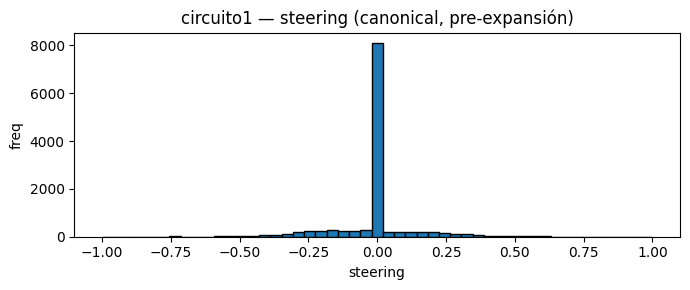

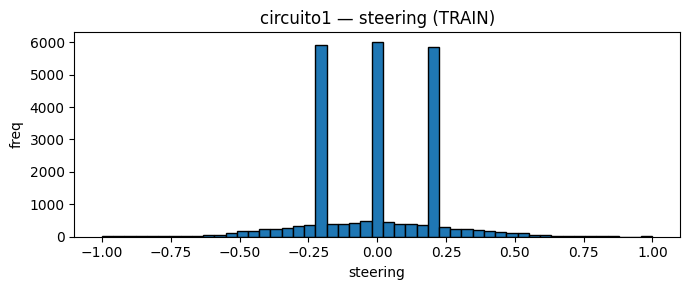

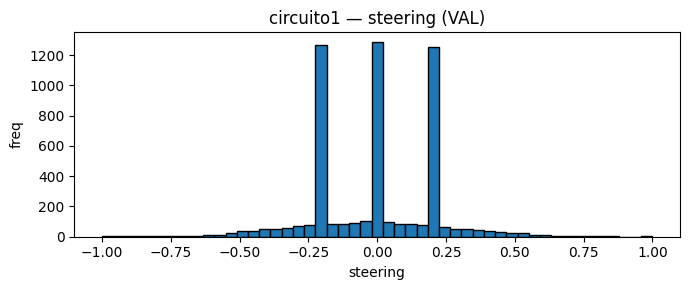

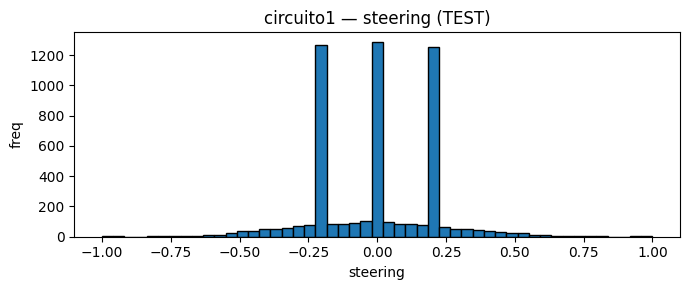

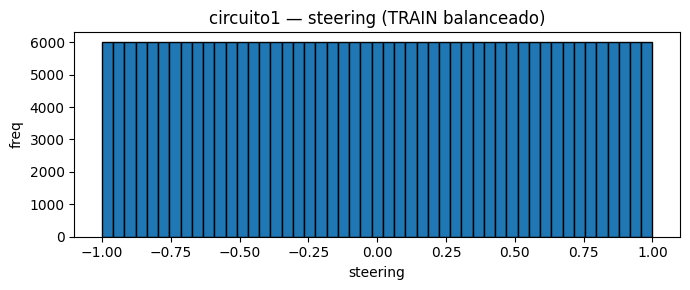

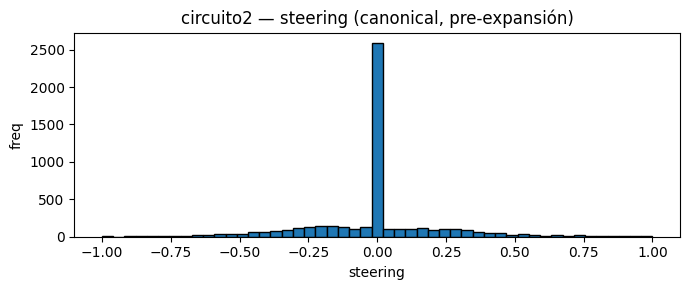

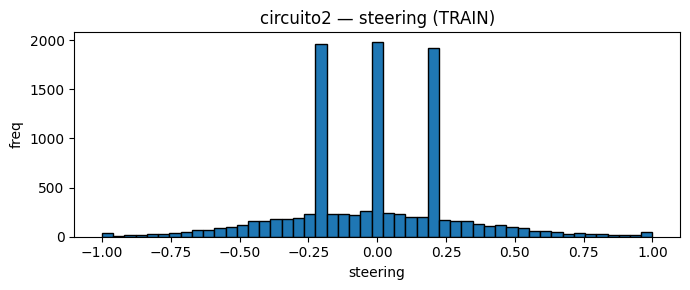

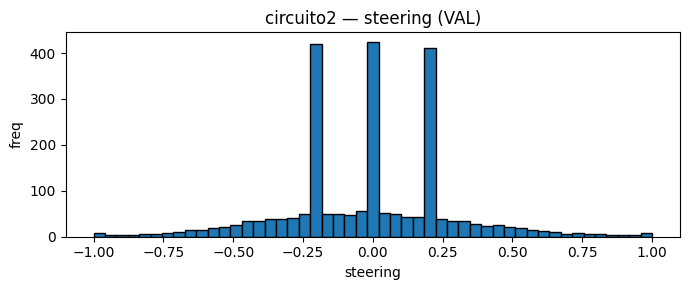

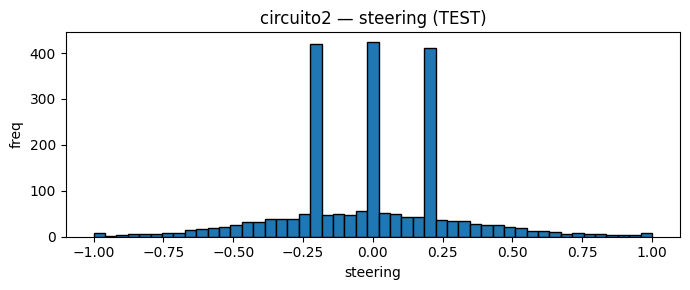

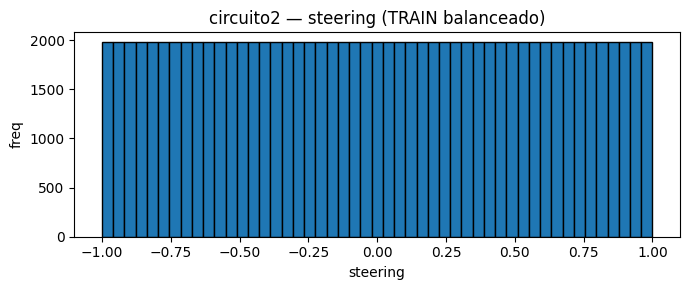

,run,n_subruns,n_canonical,n_train,n_val,n_test,n_total_after_expand,expansion_factor,has_train_balanced
0,circuito1,4,11895,24981,5357,5347,35685,3.0,True
1,circuito2,4,5168,10854,2325,2325,15504,3.0,True


Guardado resumen global: /home/cesar/proyectos/TFM_SNN/data/processed/eda_all/summary_runs.csv


In [4]:
# =============================================================================
# 2.6) EDA para TODOS los circuitos (RUNS) — tablas + gráficos por circuito
# =============================================================================
from pathlib import Path
import json, numpy as np, pandas as pd
import matplotlib.pyplot as plt

def _top_folder(pathstr: str) -> str:
    s = str(pathstr).replace("\\", "/").lstrip("/")
    return s.split("/")[0] if "/" in s else s

def _plot_hist(series, title, edges, save_path=None):
    s = pd.to_numeric(series, errors="coerce").dropna().clip(-1,1)
    plt.figure(figsize=(7,3))
    plt.hist(s, bins=edges, edgecolor="black")
    plt.title(title); plt.xlabel("steering"); plt.ylabel("freq")
    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=140)
    plt.show()
    plt.close()

def _bin_counts(series, edges):
    s = pd.to_numeric(series, errors="coerce").dropna().clip(-1,1)
    idx = pd.cut(s, bins=edges, include_lowest=True, labels=False)
    vc = idx.value_counts().sort_index()
    labels = [
        (f"[{edges[i]:.2f},{edges[i+1]:.2f})" if i < len(edges)-2
         else f"[{edges[i]:.2f},{edges[i+1]:.2f}]")
        for i in range(len(edges)-1)
    ]
    return pd.DataFrame({
        "bin": labels,
        "count": vc.reindex(range(len(edges)-1)).fillna(0).astype(int).values
    })

# Bins a usar (coherente con la preparación)
bins = CFG.bins if hasattr(CFG, "bins") else int(PREP.get("bins", 21))
edges = np.linspace(-1.0, 1.0, bins)

rows_summary = []
for RUN in RUNS:
    base_out = PROC / RUN
    if not base_out.exists():
        print(f"[WARN] {RUN}: no existe {base_out}, salto.")
        continue

    # Carga robusta de CSVs por circuito
    try:
        df_c  = pd.read_csv(base_out / "canonical.csv")  # pre-expansión
        df_tr = pd.read_csv(base_out / "train.csv")
        df_va = pd.read_csv(base_out / "val.csv")
        df_te = pd.read_csv(base_out / "test.csv")
    except Exception as e:
        print(f"[ERROR] {RUN}: {e}")
        continue
    df_bal = pd.read_csv(base_out / "train_balanced.csv") if (base_out / "train_balanced.csv").exists() else None

    # Subvueltas detectadas (vuelta1/vuelta2/...) en canonical
    df_c["subrun"] = df_c["center"].map(_top_folder)
    subruns = df_c["subrun"].value_counts().sort_index()

    # Tamaños y factor de expansión (≈3 si expandimos L/R sin pérdidas)
    n_c  = len(df_c)
    n_tr, n_va, n_te = len(df_tr), len(df_va), len(df_te)
    n_all = n_tr + n_va + n_te
    factor_expansion = (n_all / n_c) if n_c else np.nan

    # Directorio de EDA por circuito
    eda_dir = base_out / "eda"
    eda_dir.mkdir(parents=True, exist_ok=True)

    # Histogramas por split
    _plot_hist(df_c["steering"],  f"{RUN} — steering (canonical, pre-expansión)", edges, eda_dir/"hist_canonical.png")
    _plot_hist(df_tr["steering"], f"{RUN} — steering (TRAIN)", edges,              eda_dir/"hist_train.png")
    _plot_hist(df_va["steering"], f"{RUN} — steering (VAL)", edges,                eda_dir/"hist_val.png")
    _plot_hist(df_te["steering"], f"{RUN} — steering (TEST)", edges,               eda_dir/"hist_test.png")
    if df_bal is not None:
        _plot_hist(df_bal["steering"], f"{RUN} — steering (TRAIN balanceado)", edges, eda_dir/"hist_train_balanced.png")

    # Tabla de bins por circuito
    tbl_c  = _bin_counts(df_c["steering"],  edges).rename(columns={"count":"count_canonical"})
    tbl_tr = _bin_counts(df_tr["steering"], edges).rename(columns={"count":"count_train"})
    tbl_va = _bin_counts(df_va["steering"], edges).rename(columns={"count":"count_val"})
    tbl_te = _bin_counts(df_te["steering"], edges).rename(columns={"count":"count_test"})
    tbl = tbl_c.merge(tbl_tr, on="bin").merge(tbl_va, on="bin").merge(tbl_te, on="bin")
    if df_bal is not None:
        tbl_bal = _bin_counts(df_bal["steering"], edges).rename(columns={"count":"count_train_bal"})
        tbl = tbl.merge(tbl_bal, on="bin", how="left")

    tbl.to_csv(eda_dir/"bins_counts.csv", index=False)

    # Resumen JSON por circuito (para trazabilidad en la memoria)
    summary = {
        "run": RUN,
        "subruns": subruns.to_dict(),
        "n_canonical": int(n_c),
        "n_train": int(n_tr), "n_val": int(n_va), "n_test": int(n_te),
        "n_total_after_expand": int(n_all),
        "expansion_factor": float(factor_expansion),
        "bins": int(bins),
        "has_train_balanced": bool(df_bal is not None),
    }
    (eda_dir/"summary.json").write_text(json.dumps(summary, indent=2), encoding="utf-8")

    # Fila para el resumen global
    rows_summary.append({
        "run": RUN,
        "n_subruns": int(len(subruns)),
        "n_canonical": int(n_c),
        "n_train": int(n_tr), "n_val": int(n_va), "n_test": int(n_te),
        "n_total_after_expand": int(n_all),
        "expansion_factor": float(factor_expansion),
        "has_train_balanced": bool(df_bal is not None),
    })

# Resumen global de todos los circuitos
eda_all = PROC / "eda_all"
eda_all.mkdir(parents=True, exist_ok=True)
df_sum = pd.DataFrame(rows_summary)
display(df_sum.sort_values("run") if not df_sum.empty else df_sum)
out_csv = eda_all/"summary_runs.csv"
df_sum.to_csv(out_csv, index=False)
print("Guardado resumen global:", out_csv)


<a id="sec-04"></a>
## 4) Paso a paso (opcional) — depuración

Activa el bloque comentado si quieres inspeccionar **cada etapa** en un *run* concreto:
- Cargar `train.csv`,
- Balancear por imágenes con los parámetros actuales,
- Revisar `stats` y rutas generadas.

Úsalo solo con fines de depuración: reproduce manualmente lo que ya ejecuta la celda 2.


[↑ Volver al índice](#toc)


In [5]:
# run = RUNS[0]
# base = RAW / run
# out  = PROC / run
# out.mkdir(parents=True, exist_ok=True)

# _csv, _stats = balance_train_with_augmented_images(
#     train_csv=out / "train.csv",
#     raw_run_dir=base,
#     out_run_dir=out,
#     bins=CFG.bins,
#     target_per_bin=target_per_bin,
#     cap_per_bin=cap_per_bin,
#     seed=CFG.seed,
#     aug=AUG,
#     idempotent=True,
#     overwrite=False,
# )
# print("Balanced CSV:", _csv, "| stats:", _stats)


<a id="sec-05"></a>
## 5) Histogramas: original vs balanced

Visualiza y compara la **distribución de `steering`** (recortada a `[-1,1]`) en:
- `train.csv` (original) y
- `train_balanced.csv` (si existe)

para **cada** *run*. Estos gráficos ayudan a documentar el efecto del balanceo y a justificar su impacto en los experimentos.

[↑ Volver al índice](#toc)


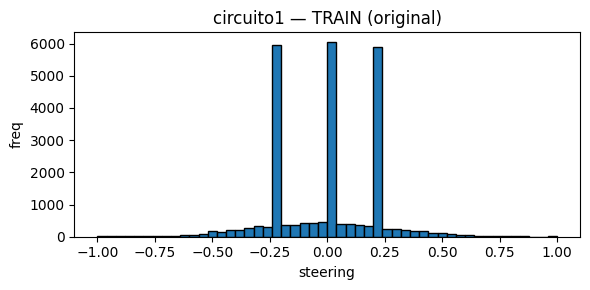

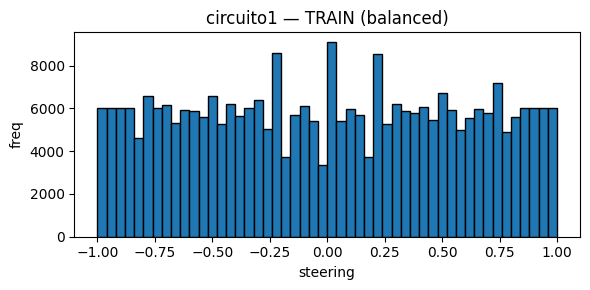

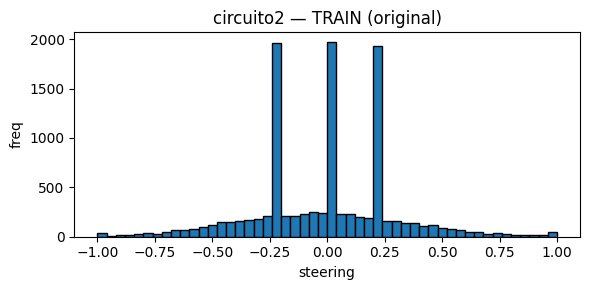

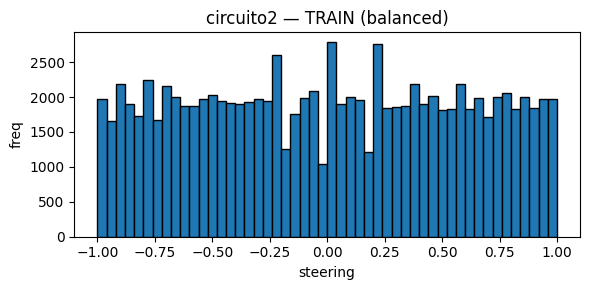

In [6]:
import matplotlib.pyplot as plt, numpy as np, pandas as pd

def plot_hist(csv_path, title, bins):
    df = pd.read_csv(csv_path)
    s = df["steering"].astype(float).clip(-1,1)
    plt.figure(figsize=(6,3))
    plt.hist(s, bins=bins, edgecolor="black")
    plt.title(title); plt.xlabel("steering"); plt.ylabel("freq")
    plt.tight_layout()
    plt.show(); plt.close()

for run in RUNS:
    base = PROC / run
    plot_hist(base / "train.csv", f"{run} — TRAIN (original)", CFG.bins)
    if (base / "train_balanced.csv").exists():
        plot_hist(base / "train_balanced.csv", f"{run} — TRAIN (balanced)", CFG.bins)


**Listo.** Ya puedes ir a `03_TRAIN_EVAL.ipynb` y activar `USE_OFFLINE_BALANCED = True`
para consumir `tasks_balanced.json` (o dejarlo en `False` si quieres usar `tasks.json`).
